In [1]:
import pandas as pd
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import sys

In [2]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image

In [3]:
is_in_colab = True

if(sys.platform == 'linux'):
  print('Using Ramdisk')
  if(is_in_colab):
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    
    if(not os.path.isfile('/content/data.zip')):
      !cp -r "/content/drive/My Drive/Machine Learning/deliver/DeepLearning/data.zip" /content/
    if(not os.path.exists('/content/ramdisk/')):
      !mkdir /content/ramdisk/
    if(not os.path.exists('/content/ramdisk/data/')):
      !mount -t tmpfs -o size=500m tmpfs /content/ramdisk
      !unzip /content/data.zip -d /content/ramdisk/

    dir_data = '/content/ramdisk/data'
    dir_save = '/content/drive/My Drive/Machine Learning/deliver/DeepLearning/'
  else:
    if(not os.path.exists('./ramdisk/')):
      !mkdir /content/ramdisk/

    if(not os.path.exists('/content/ramdisk/data/')):
      !mount -t tmpfs -o size=500m tmpfs /content/ramdisk
      !unzip ./data.zip -d ./ramdisk/
    
    dir_data = 'ramdisk/data'
    dir_save = './'
else:
  dir_data = 'data'
  dir_save = './'

dir_train = 'Train'
dir_test = 'Test'

Streaming output truncated to the last 5000 lines.
  inflating: /content/ramdisk/data/Train/5/00005_00053_00015.png  
  inflating: /content/ramdisk/data/Train/5/00005_00053_00016.png  
  inflating: /content/ramdisk/data/Train/5/00005_00053_00017.png  
  inflating: /content/ramdisk/data/Train/5/00005_00053_00018.png  
  inflating: /content/ramdisk/data/Train/5/00005_00053_00019.png  
  inflating: /content/ramdisk/data/Train/5/00005_00053_00020.png  
  inflating: /content/ramdisk/data/Train/5/00005_00053_00021.png  
  inflating: /content/ramdisk/data/Train/5/00005_00053_00022.png  
  inflating: /content/ramdisk/data/Train/5/00005_00053_00023.png  
  inflating: /content/ramdisk/data/Train/5/00005_00053_00024.png  
  inflating: /content/ramdisk/data/Train/5/00005_00053_00025.png  
  inflating: /content/ramdisk/data/Train/5/00005_00053_00026.png  
  inflating: /content/ramdisk/data/Train/5/00005_00053_00027.png  
  inflating: /content/ramdisk/data/Train/5/00005_00053_00028.png  
  inflating

In [4]:
train_csv = os.path.join(dir_data, 'Train.csv')
test_csv = os.path.join(dir_data, 'Test.csv')
meta_csv = os.path.join(dir_data, 'Meta.csv')

In [5]:
df_train_csv = pd.read_csv(train_csv, dtype=object)
df_test_csv = pd.read_csv(test_csv, dtype=object)
df_meta_csv = pd.read_csv(meta_csv, dtype=object)


#df_train_csv['ClassId'] = str(df_train_csv['ClassId'])
#df_test_csv['ClassId'] = str(df_test_csv['ClassId'])
#df_meta_csv.sort_values(by=['ClassId'], inplace=True)

In [6]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

In [7]:
#because the min of width and height are all 25, in both train and test
#VGG16 min size is 32
#target_size = (25,25)
target_size = (32,32)
class_size = df_meta_csv['ClassId'].count()
validation_rate = 0.25
training_rate = 1.0 - validation_rate
batch_size = 32
learning_rate = 0.001

## Observe the Data

In [8]:
df_train_csv.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [9]:
df_test_csv.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [10]:
df_meta_csv.head()

,Path,ClassId,ShapeId,ColorId,SignId
0,Meta/27.png,27,0,0,1.32
1,Meta/0.png,0,1,0,3.29
2,Meta/1.png,1,1,0,3.29
3,Meta/10.png,10,1,0,3.27
4,Meta/11.png,11,0,0,1.22


In [11]:
df_train_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39209 entries, 0 to 39208
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Width    39209 non-null  object
 1   Height   39209 non-null  object
 2   Roi.X1   39209 non-null  object
 3   Roi.Y1   39209 non-null  object
 4   Roi.X2   39209 non-null  object
 5   Roi.Y2   39209 non-null  object
 6   ClassId  39209 non-null  object
 7   Path     39209 non-null  object
dtypes: object(8)
memory usage: 2.4+ MB


In [12]:
df_test_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12630 entries, 0 to 12629
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Width    12630 non-null  object
 1   Height   12630 non-null  object
 2   Roi.X1   12630 non-null  object
 3   Roi.Y1   12630 non-null  object
 4   Roi.X2   12630 non-null  object
 5   Roi.Y2   12630 non-null  object
 6   ClassId  12630 non-null  object
 7   Path     12630 non-null  object
dtypes: object(8)
memory usage: 789.5+ KB


In [13]:
df_meta_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Path     43 non-null     object
 1   ClassId  43 non-null     object
 2   ShapeId  43 non-null     object
 3   ColorId  43 non-null     object
 4   SignId   43 non-null     object
dtypes: object(5)
memory usage: 1.8+ KB


In [14]:
df_train_csv['Width'].describe()

count     39209
unique      187
top          34
freq       1327
Name: Width, dtype: object

In [15]:
df_train_csv['Height'].describe()

count     39209
unique      176
top          33
freq       1380
Name: Height, dtype: object

In [16]:
df_test_csv['Width'].describe()

count     12630
unique      173
top          31
freq        479
Name: Width, dtype: object

In [17]:
df_test_csv['Height'].describe()

count     12630
unique      163
top          32
freq        479
Name: Height, dtype: object

(array([ 360.,  210., 2220., 2250., 1410., 1980., 1860.,  420., 1440.,
        1410., 1470., 2010., 1320., 2100., 2160.,  780.,  630.,  420.,
        1110., 1200.,  210.,  330.,  390.,  510.,  270., 1500.,  600.,
         240.,  540.,  270.,  450.,  780.,  240.,  689.,  420., 1200.,
         390.,  210., 2070.,  300.,  360.,  240.,  240.]),
 array([ 0.        ,  0.97674419,  1.95348837,  2.93023256,  3.90697674,
         4.88372093,  5.86046512,  6.8372093 ,  7.81395349,  8.79069767,
         9.76744186, 10.74418605, 11.72093023, 12.69767442, 13.6744186 ,
        14.65116279, 15.62790698, 16.60465116, 17.58139535, 18.55813953,
        19.53488372, 20.51162791, 21.48837209, 22.46511628, 23.44186047,
        24.41860465, 25.39534884, 26.37209302, 27.34883721, 28.3255814 ,
        29.30232558, 30.27906977, 31.25581395, 32.23255814, 33.20930233,
        34.18604651, 35.1627907 , 36.13953488, 37.11627907, 38.09302326,
        39.06976744, 40.04651163, 41.02325581, 42.        ]),
 <a list of

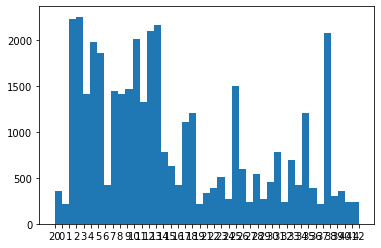

In [18]:
plt.hist(df_train_csv['ClassId'], bins = class_size)

(array([150., 720., 690., 210., 420., 390., 690., 480., 390., 450., 150.,
        660., 480.,  90.,  90.,  60., 450., 720., 660., 630., 360., 120.,
        750., 450., 150.,  90., 210., 180., 150., 120., 270.,  60.,  90.,
        150., 120.,  90.,  60., 270.,  60.,  60.,  90.,  90.,  60.]),
 array([ 0.        ,  0.97674419,  1.95348837,  2.93023256,  3.90697674,
         4.88372093,  5.86046512,  6.8372093 ,  7.81395349,  8.79069767,
         9.76744186, 10.74418605, 11.72093023, 12.69767442, 13.6744186 ,
        14.65116279, 15.62790698, 16.60465116, 17.58139535, 18.55813953,
        19.53488372, 20.51162791, 21.48837209, 22.46511628, 23.44186047,
        24.41860465, 25.39534884, 26.37209302, 27.34883721, 28.3255814 ,
        29.30232558, 30.27906977, 31.25581395, 32.23255814, 33.20930233,
        34.18604651, 35.1627907 , 36.13953488, 37.11627907, 38.09302326,
        39.06976744, 40.04651163, 41.02325581, 42.        ]),
 <a list of 43 Patch objects>)

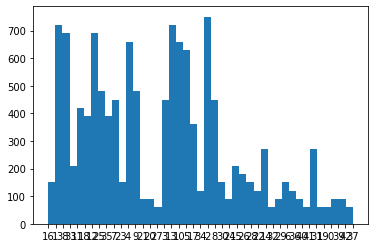

In [19]:
plt.hist(df_test_csv['ClassId'], bins = class_size)

## import the images

In [20]:
train_datagen1 = ImageDataGenerator(rescale=1./255.,
                                    validation_split=validation_rate)

In [21]:
train_datagen2 = ImageDataGenerator(rotation_range=10,
                                    zoom_range=0.15,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    shear_range=0.15,
                                    horizontal_flip=False,
                                    vertical_flip=False,
                                    fill_mode="nearest",
                                    rescale=1./255.,
                                    validation_split=validation_rate)

In [22]:
test_datagen = ImageDataGenerator(rescale=1./255.)

In [23]:
train_data1 = train_datagen1.flow_from_directory(
    os.path.join(dir_data, dir_train),
    subset="training",
    target_size = target_size,
    batch_size = batch_size,
    class_mode="categorical")
    
valid_data1 = train_datagen1.flow_from_directory(
    os.path.join(dir_data, dir_train),
    subset="validation",
    target_size = target_size,
    batch_size = batch_size,
    class_mode="categorical")

Found 29416 images belonging to 43 classes.
Found 9793 images belonging to 43 classes.


In [24]:
#check the value for train_data1
train_data1_label = train_data1.labels.tolist()
valid_data1_label = valid_data1.labels.tolist()

dict_train_label_count = {}
dict_valid_label_count = {}

for count in range(class_size):
    dict_train_label_count[count] = 0
    dict_valid_label_count[count] = 0

for count in range(len(train_data1_label)):
    dict_train_label_count[train_data1_label[count]] += 1

for count in range(len(valid_data1_label)):
    dict_valid_label_count[valid_data1_label[count]] += 1

dict_train_valid_ratio = {}
for count in range(class_size):
    dict_train_valid_ratio[count] = dict_train_label_count[count] / dict_valid_label_count[count]

print(dict_train_valid_ratio)

{0: 3.0384615384615383, 1: 3.0, 2: 3.00398406374502, 3: 3.0, 4: 3.0, 5: 3.0, 6: 3.0, 7: 3.0127388535031847, 8: 3.0, 9: 3.0072202166064983, 10: 3.0, 11: 3.0384615384615383, 12: 3.00355871886121, 13: 3.0, 14: 3.024390243902439, 15: 3.020618556701031, 16: 3.015748031496063, 17: 3.029850746268657, 18: 3.0, 19: 3.0, 20: 3.0, 21: 3.0, 22: 3.029850746268657, 23: 3.0056818181818183, 24: 3.017857142857143, 25: 3.0, 26: 3.0, 27: 3.005813953488372, 28: 3.0, 29: 3.0, 30: 3.020618556701031, 31: 3.0384615384615383, 32: 3.003868471953578, 33: 3.0, 34: 3.0, 35: 3.0, 36: 3.0, 37: 3.0, 38: 3.0, 39: 3.0, 40: 3.0, 41: 3.0056818181818183, 42: 3.005449591280654}


In [25]:
"""
train_data = train_datagen.flow_from_dataframe(
    dataframe = df_train_csv,
    directory = dir_data,
    x_col = 'Path',
    y_col = 'ClassId',
    subset="training",
    target_size = target_size,
    batch_size = batch_size,
    class_mode="categorical")
    
valid_data = train_datagen.flow_from_dataframe(
    dataframe = df_test_csv,
    directory = dir_data,
    x_col = 'Path',
    y_col = 'ClassId',
    subset="validation",
    target_size = target_size,
    batch_size = batch_size,
    class_mode="categorical")
"""

'\ntrain_data = train_datagen.flow_from_dataframe(\n    dataframe = df_train_csv,\n    directory = dir_data,\n    x_col = \'Path\',\n    y_col = \'ClassId\',\n    subset="training",\n    target_size = target_size,\n    batch_size = batch_size,\n    class_mode="categorical")\n    \nvalid_data = train_datagen.flow_from_dataframe(\n    dataframe = df_test_csv,\n    directory = dir_data,\n    x_col = \'Path\',\n    y_col = \'ClassId\',\n    subset="validation",\n    target_size = target_size,\n    batch_size = batch_size,\n    class_mode="categorical")\n'

In [26]:
test_data = test_datagen.flow_from_dataframe(
    dataframe = df_test_csv,
    directory = dir_data,
    x_col = 'Path',
    y_col = 'ClassId',
    target_size = target_size,
    class_mode="categorical")

Found 12630 validated image filenames belonging to 43 classes.


## Create Model

In [27]:
conv_base= VGG16(weights='imagenet',
                    include_top=False,
                    input_shape = (target_size[0],target_size[1],3))

58889256/58889256 [==============================] - 0s 0us/step


In [28]:
model1 = models.Sequential()
model1.add(conv_base)
model1.add(layers.Flatten())
model1.add(layers.Dense(512,activation='relu'))
model1.add(layers.Dense(class_size,activation='softmax'))

In [29]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 43)                22059     
                                                                 
Total params: 14,999,403
Trainable params: 14,999,403
Non-trainable params: 0
_________________________________________________________________


In [30]:
epochs1 = 30

conv_base.trainable = False

opt1 = optimizers.Adam(lr=learning_rate, decay=learning_rate / (epochs1 * 0.5))

model1.compile(loss="categorical_crossentropy",
                optimizer=opt1,
                metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [31]:
history1 = model1.fit(train_data1, 
                    #steps_per_epoch = 75,
                    #validation_steps = 25,
                    epochs = epochs1, 
                    validation_data = valid_data1)

Epoch 1/30
920/920 [==============================] - 30s 23ms/step - loss: 1.6044 - accuracy: 0.5164 - val_loss: 1.9018 - val_accuracy: 0.4338
Epoch 2/30
920/920 [==============================] - 20s 21ms/step - loss: 0.9772 - accuracy: 0.6931 - val_loss: 1.9678 - val_accuracy: 0.4452
Epoch 3/30
920/920 [==============================] - 21s 23ms/step - loss: 0.7549 - accuracy: 0.7615 - val_loss: 2.0353 - val_accuracy: 0.4760
Epoch 4/30
920/920 [==============================] - 20s 22ms/step - loss: 0.6116 - accuracy: 0.8083 - val_loss: 2.1472 - val_accuracy: 0.4601
Epoch 5/30
920/920 [==============================] - 20s 22ms/step - loss: 0.5175 - accuracy: 0.8392 - val_loss: 2.1828 - val_accuracy: 0.4801
Epoch 6/30
920/920 [==============================] - 21s 23ms/step - loss: 0.4457 - accuracy: 0.8601 - val_loss: 2.2708 - val_accuracy: 0.4761
Epoch 7/30
920/920 [==============================] - 20s 22ms/step - loss: 0.3879 - accuracy: 0.8802 - val_loss: 2.3617 - val_accuracy:

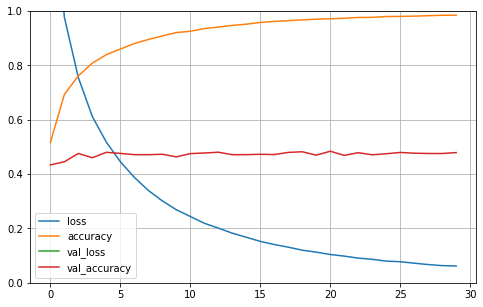

In [32]:
pd.DataFrame(history1.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [33]:
import pickle
with open(os.path.join(dir_save, './history1'), 'wb') as file_pi1:
    pickle.dump(history1.history, file_pi1)

In [34]:
model1.save_weights(os.path.join(dir_save, './module1_weight'))

In [35]:
train_data2 = train_datagen2.flow_from_directory(
    os.path.join(dir_data, dir_train),
    subset="training",
    target_size = target_size,
    batch_size = batch_size,
    class_mode="categorical")
    
valid_data2 = train_datagen2.flow_from_directory(
    os.path.join(dir_data, dir_train),
    subset="validation",
    target_size = target_size,
    batch_size = batch_size,
    class_mode="categorical")

Found 29416 images belonging to 43 classes.
Found 9793 images belonging to 43 classes.


In [36]:
model2 = models.Sequential()
model2.add(conv_base)
model2.add(layers.Flatten())
model2.add(layers.BatchNormalization())
model2.add(layers.Dense(512,activation='relu'))
model2.add(layers.Dropout(rate=0.5))
model2.add(layers.Dense(class_size,activation='softmax'))

In [37]:
epochs2 = 30

conv_base.trainable = False

opt2 = optimizers.Adam(lr=learning_rate, decay=learning_rate / (epochs2 * 0.5))

model2.compile(loss="categorical_crossentropy",
                optimizer=opt2,
                metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [38]:
history2 = model2.fit(train_data2,  
                    #steps_per_epoch = 75,
                    #validation_steps = 25,
                    epochs = epochs2, 
                    validation_data = valid_data2)

Epoch 1/30
920/920 [==============================] - 43s 46ms/step - loss: 1.8263 - accuracy: 0.4562 - val_loss: 2.0634 - val_accuracy: 0.4180
Epoch 2/30
920/920 [==============================] - 43s 47ms/step - loss: 1.2968 - accuracy: 0.5888 - val_loss: 2.1711 - val_accuracy: 0.4343
Epoch 3/30
920/920 [==============================] - 43s 47ms/step - loss: 1.1483 - accuracy: 0.6275 - val_loss: 2.1659 - val_accuracy: 0.4410
Epoch 4/30
920/920 [==============================] - 43s 47ms/step - loss: 1.0536 - accuracy: 0.6566 - val_loss: 2.2557 - val_accuracy: 0.4393
Epoch 5/30
920/920 [==============================] - 43s 46ms/step - loss: 0.9898 - accuracy: 0.6754 - val_loss: 2.2791 - val_accuracy: 0.4346
Epoch 6/30
920/920 [==============================] - 43s 47ms/step - loss: 0.9326 - accuracy: 0.6940 - val_loss: 2.3596 - val_accuracy: 0.4516
Epoch 7/30
920/920 [==============================] - 42s 45ms/step - loss: 0.8901 - accuracy: 0.7079 - val_loss: 2.4135 - val_accuracy:

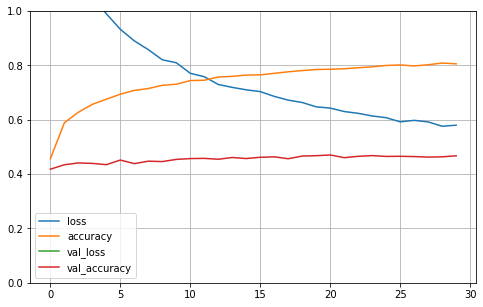

In [39]:
pd.DataFrame(history2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [40]:
with open(os.path.join(dir_save, './history2'), 'wb') as file_pi2:
    pickle.dump(history2.history, file_pi2)

In [41]:
model2.save_weights(os.path.join(dir_save, './module2_weight'))

## New Stucture

In [42]:
train_data2 = train_datagen2.flow_from_directory(
    os.path.join(dir_data, dir_train),
    subset="training",
    target_size = target_size,
    batch_size = batch_size,
    class_mode="categorical")
    
valid_data2 = train_datagen2.flow_from_directory(
    os.path.join(dir_data, dir_train),
    subset="validation",
    target_size = target_size,
    batch_size = batch_size,
    class_mode="categorical")

Found 29416 images belonging to 43 classes.
Found 9793 images belonging to 43 classes.


In [43]:
train_data1 = train_datagen1.flow_from_directory(
    os.path.join(dir_data, dir_train),
    subset="training",
    target_size = target_size,
    batch_size = batch_size,
    class_mode="categorical")
    
valid_data1 = train_datagen1.flow_from_directory(
    os.path.join(dir_data, dir_train),
    subset="validation",
    target_size = target_size,
    batch_size = batch_size,
    class_mode="categorical")

Found 29416 images belonging to 43 classes.
Found 9793 images belonging to 43 classes.


In [44]:
model3 = models.Sequential([    
    layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(target_size[0],target_size[1],3)),
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.BatchNormalization(axis=-1),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.BatchNormalization(axis=-1),
    
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.5),
    
    layers.Dense(43, activation='softmax')
])

In [45]:
epochs3 = 30

conv_base.trainable = False

opt3 = optimizers.Adam(lr=learning_rate, decay=learning_rate / (epochs3 * 0.5))

model3.compile(loss="categorical_crossentropy",
                optimizer=opt3,
                metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [46]:
history3 = model3.fit(train_data2,  
                    epochs = epochs3, 
                    validation_data = valid_data2)

Epoch 1/30
920/920 [==============================] - 51s 53ms/step - loss: 0.8986 - accuracy: 0.7545 - val_loss: 0.5621 - val_accuracy: 0.8429
Epoch 2/30
920/920 [==============================] - 48s 52ms/step - loss: 0.1528 - accuracy: 0.9520 - val_loss: 0.5284 - val_accuracy: 0.8533
Epoch 3/30
920/920 [==============================] - 48s 52ms/step - loss: 0.1004 - accuracy: 0.9681 - val_loss: 0.2312 - val_accuracy: 0.9347
Epoch 4/30
920/920 [==============================] - 48s 52ms/step - loss: 0.0732 - accuracy: 0.9775 - val_loss: 0.3885 - val_accuracy: 0.9061
Epoch 5/30
920/920 [==============================] - 48s 52ms/step - loss: 0.0594 - accuracy: 0.9821 - val_loss: 0.2525 - val_accuracy: 0.9259
Epoch 6/30
920/920 [==============================] - 47s 51ms/step - loss: 0.0579 - accuracy: 0.9826 - val_loss: 0.3275 - val_accuracy: 0.9160
Epoch 7/30
920/920 [==============================] - 47s 51ms/step - loss: 0.0414 - accuracy: 0.9869 - val_loss: 0.3236 - val_accuracy:

In [47]:
import pickle
with open(os.path.join(dir_save, './history3'), 'wb') as file_pi2:
    pickle.dump(history3.history, file_pi2)

model3.save_weights(os.path.join(dir_save, './module3_weight'))

In [48]:
model4 = models.Sequential([    
    layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(target_size[0],target_size[1],3)),
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    
    layers.Dense(43, activation='softmax')
])

In [49]:
epochs4 = 30

conv_base.trainable = False

opt4 = optimizers.Adam(lr=learning_rate, decay=learning_rate / (epochs4 * 0.5))

model4.compile(loss="categorical_crossentropy",
                optimizer=opt4,
                metrics=['accuracy'])            

In [50]:
history4 = model4.fit(train_data1,  
                    epochs = epochs4, 
                    validation_data = valid_data1)

Epoch 1/30
920/920 [==============================] - 23s 24ms/step - loss: 0.5422 - accuracy: 0.8505 - val_loss: 0.2834 - val_accuracy: 0.9249
Epoch 2/30
920/920 [==============================] - 23s 25ms/step - loss: 0.0588 - accuracy: 0.9834 - val_loss: 0.2158 - val_accuracy: 0.9499
Epoch 3/30
920/920 [==============================] - 22s 24ms/step - loss: 0.0278 - accuracy: 0.9925 - val_loss: 0.3067 - val_accuracy: 0.9443
Epoch 4/30
920/920 [==============================] - 23s 25ms/step - loss: 0.0205 - accuracy: 0.9938 - val_loss: 0.2777 - val_accuracy: 0.9420
Epoch 5/30
920/920 [==============================] - 22s 24ms/step - loss: 0.0152 - accuracy: 0.9955 - val_loss: 0.3153 - val_accuracy: 0.9401
Epoch 6/30
920/920 [==============================] - 23s 25ms/step - loss: 0.0160 - accuracy: 0.9955 - val_loss: 0.2578 - val_accuracy: 0.9475
Epoch 7/30
920/920 [==============================] - 22s 24ms/step - loss: 0.0051 - accuracy: 0.9988 - val_loss: 0.2268 - val_accuracy:

In [51]:
import pickle
with open(os.path.join(dir_save, './history4'), 'wb') as file_pi2:
    pickle.dump(history4.history, file_pi2)

model4.save_weights(os.path.join(dir_save, './module4_weight'))

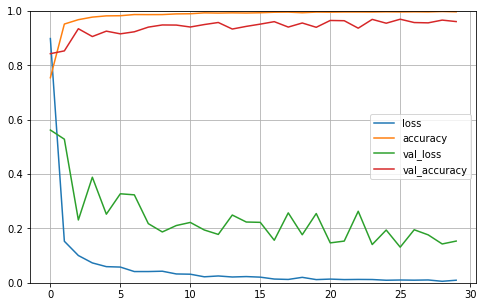

In [52]:
pd.DataFrame(history3.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

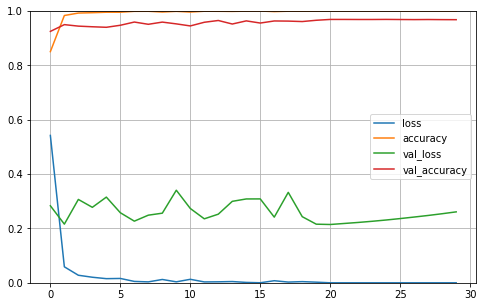

In [53]:
pd.DataFrame(history4.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()